   # Comparison of Beaches
   # IBM Capstone Project - Gokhan Ekici - 06/07/2020

#### Definition of The Problem 
When you move to a new country or when you would like visit a new country for sun, sea and beaches, you have many websites that provide information about you options. Just like moving to a new neighborhood you want to learn the details, but some details are confusing and some of the content you have to read biased. When you search for “best beaches in US” on Google for example, you receive over 400.000 results. And although you know Google sorts them in a relevant order, when you check those results you are confused, you see that the top lists do not overlap, and you might get confused.  
<br> <br>
On the other hand, when you are deciding to buy a tool, a furniture a holiday package you mostly rely on people with similar tastes like you. But if you are new to a country, if you will visit it for the first time then the chances that you will find someone to understand what you want and respond to it with a good recommendation gets lower. 
<br> <br>
Today as we have so much information why would not I make my own decision, based on available data out there? At least a similarity analysis, a clustering algorithm might help us all choose places to see given the similarity between the places we like our favorite beach and the surrounding venues and neighborhood. This could be a self-service model which could lead to an affiliate model for tourism agencies, or could be directly used by tourism agencies.  
<br> <br>
<strong>A choice of a beach holiday for me has 3 main elements. </strong>
<ol>
<li>The beach, its rating and the neighborhood restaurants and cafes and bars etc.</li>
<li>The climate</li>
<li>Third item</li>
<li>The accommodation choices</li>
</ol>
<br> <br>
During this analysis I will focus on the first 2 as most beautiful beaches already have many accommodation choices and there is plenty of reliable price and feature data on booking.com, hotels.com and Airbnb. I think the hard part is finding the right beach. 
<br> <br>
<strong> Data </strong>
<br> <br>
I used 3 main data sets available online, the ones available for free for the sake of this Capstone Project.
<ol>
<li>A list of best beaches in US derived from USNEWS Travel site, Tripadvisor and some others and Foursquare, Tripadvisor and Google ratings for these beaches.</li>
<li>Climate data from visualcrossing.com</li>
<li>Foursquare Venue Data available through Foursquare API</li>
</ol>
<br>
The Beach based rating, important climate information (temperature, humidity etc.), venues and categories of venues in the neighborhood are normalized and clustered so that we can compare one or more favorite beaches of ours to the new ones we have no idea of and want to see how they fit into our tastes. 
I used K-Means and DBSCAN for clustering a short list of beaches and create a model that can be used for analysis for other beaches etc. as well.


### 1. Import Libraries

In [2]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np # library to handle data in a vectorized manner
import io
import requests # library to handle requests
import csv
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import urllib.request
import codecs

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## 2. Define Credentials

<strong> Foursquare: </strong>

In [5]:
CLIENT_ID = 'NIN4QMD5VVF5TXXKVWAIUC03UM05HPVEWEPFN5T2Z5PPWL3W' # your Foursquare ID
CLIENT_SECRET = 'BI1KACYBEKNKLLNAGLO5ZLZZKNSHT145ELMDZ5S13BU0AXRW' # your Foursquare Secret
VERSION = '20180605'

<strong> Visual Crossing: </strong>
#See https://www.visualcrossing.com/resources/blog/how-to-load-historical-weather-data-using-python-without-scraping/ for more.

In [6]:
VISUALC = 'Y2UFS7PGJBNJRATCQ0Z5SLGMV'

## 3.1 Beaches

We get the list of beaches to analyze. The best beaches I found on Tripadvisor, https://travel.usnews.com/, etc. with their subjective ratings.

In [7]:
dfBeach=pd.read_csv('d:\ds\BeachList.csv')
dfBeach

,Beach,Latitude,Longitude,BeachRating
0,"Miami Beach, Florida",NaN,NaN,9.5
1,"Santa Monica,Los Angeles",NaN,NaN,9.2
2,"Virginia Beach, Virginia",NaN,NaN,8.5
3,"Destin, Florida",NaN,NaN,9.0
4,"Outer Banks, North Carolina",NaN,NaN,8.4
5,"Laguna Beach, California",NaN,NaN,9.6
6,"Ocean City, Maryland",NaN,NaN,8.8
7,"Myrtle Beach, South Carolina",NaN,NaN,9.0
8,"Ruby Beach, Washington",NaN,NaN,10.0


Alanya in Turkey is the main beach I would like to compare to the beaches in US. 
Let's have a look at Alanya first of all. The location is 

In [8]:
    address = 'Saray, Alanya'

    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

36.5499831 31.9799349


If you would like to add any other beaches to compare and see how they fit into the cluster you just remove the comment and write the name of the place below. But first you have to make sure that it has climate information with the test function first. Here is the climate information test function and below is the where you should wirte the name ofthe beach/location where tou could test the data vailability.

In [9]:
# This function is only for testing wether the location has Weather Data or not. 
# Since it is a subscribed limited service, I did not want to use too much credit for places that do not have data.. 

def getClimateInfoTest(names):
        df = pd.DataFrame(columns=['City', 'Date', 'MinTemp', 'MaxTemp', 'AvTemp', 'Humidity', 'Precipitation'])

        # Date format must be yyyy-M-d
        pars = ["GE", names, "HISTORY", VISUALC, "2019-07-5", "2019-07-5" ]


        # This is the core of our weather query URL
        BaseURL = 'http://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/'

        print('')
        print(' - Requesting weather for: ', pars[1])

        # Set up the location parameter for our query
        QueryLocation = '&location=' + urllib.parse.quote(pars[1])

        # Set up the query type parameter for our query ('FORECAST' or 'HISTORY')
        QueryType=pars[2].upper()

        # Set up the key parameter for our query
        QueryKey = '&key=' + pars[3]

        # Set up the date parameters for our query. Used only for historical weather data requests
        FromDateParam =  pars[4]
        ToDateParam =  pars[5]

        # Set up the specific parameters based on the type of query
        if QueryType == 'FORECAST':
            print(' - Fetching forecast data')
            QueryTypeParams = 'forecast?&aggregateHours=24&unitGroup=us&shortColumnNames=false'
        else:
            print(' - Fetching history for date: ', FromDateParam,'-',ToDateParam)

            # History requests require a date.  We use the same date for start and end since we only want to query a single date in this example
            QueryDate = '&startDateTime=' + FromDateParam + 'T12:00:00&endDateTime=' +ToDateParam + 'T12:00:00'
            QueryTypeParams = 'history?&aggregateHours=24&unitGroup=us&dayStartTime=0:0:00&dayEndTime=0:0:00' + QueryDate


            # Build the entire query
            URL = BaseURL + QueryTypeParams + QueryLocation + QueryKey

            print(' - Running query URL: ', URL)
            print()

            # Parse the results as CSV
            CSVBytes = urllib.request.urlopen(URL)
            CSVText = csv.reader(codecs.iterdecode(CSVBytes, 'utf-8'))

        #The API returns these values for HISTORY: Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,
        #Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,
        #Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,
        #Resolved Address,Name,Info,Conditions
        
        RowIndex = 0
        mintemp='' 
        maxtemp=''
        avtemp = '' 
        precipi = ''
        humidi = ''

        # The first row contain the headers and the additional rows each contain the weather metrics for a single day
        # To simply our code, we use the knowledge that column 0 contains the location and column 1 contains the date.  The data starts at column 4
        for Row in CSVText:
            if RowIndex == 0:
                FirstRow = Row
            else:
                print('Weather in ', Row[0], ' on ', Row[1])

                ColIndex = 0
                for Col in Row:
                    if ColIndex >= 2:
                        print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                    ColIndex += 1
            RowIndex += 1

        # If there are no CSV rows then something fundamental went wrong
        if RowIndex == 0:
            print('Sorry, but it appears that there was an error connecting to the weather server.')
            print('Please check your network connection and try again..')

        # If there is only one CSV  row then we likely got an error from the server
        if RowIndex == 1:
            print('Sorry, but it appears that there was an error retrieving the weather data.')
            print('Error: ', FirstRow)

        print()
        return(df)

In [51]:
# Test if any location has data, at least for one day in 2019
getClimateInfoTest('Saray, Alanya')



 - Requesting weather for:  Saray, Alanya
 - Fetching history for date:  2019-07-5 - 2019-07-5
 - Running query URL:  http://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=24&unitGroup=us&dayStartTime=0:0:00&dayEndTime=0:0:00&startDateTime=2019-07-5T12:00:00&endDateTime=2019-07-5T12:00:00&location=Saray%2C%20Alanya&key=Y2UFS7PGJBNJRATCQ0Z5SLGMV

Weather in  Saray, Alanya  on  07/05/2019
    Minimum Temperature  =  84.5
    Maximum Temperature  =  84.5
    Temperature  =  84.5
    Dew Point  =  75.8
    Relative Humidity  =  75.38
    Heat Index  =  93.5
    Wind Speed  =  4.7
    Wind Gust  =  
    Wind Direction  =  170
    Wind Chill  =  
    Precipitation  =  0
    Precipitation Cover  =  0
    Snow Depth  =  
    Visibility  =  12.4
    Cloud Cover  =  0
    Sea Level Pressure  =  1006.4
    Weather Type  =  
    Latitude  =  36.54941
    Longitude  =  31.98635
    Resolved Address  =  Saray, Alanya, Antalya, Türkiye
    Name

,City,Date,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation


If there is an information regarding the location you added, you could add it to the DataFrame dfBeach and put it into the basket of beaches to be clustered and analyzed. Just romove the remarks below and replace "Alanya, Turkey" with the desired beach and its rating. Rating could be your subjective view of the place out of 10, so that it will be clustered accordingly.

In [10]:
new_row = {'Beach': 'Saray, Alanya', 'BeachRating': 10}
dfBeach=dfBeach.append(new_row, ignore_index=True)

Let's now define the coordinates for all beaches in our DataFrame, dfBeach.

In [11]:
for index in range(len(dfBeach)):
    address = dfBeach['Beach'].iloc[index]
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    dfBeach['Latitude'].iloc[index] = latitude
    dfBeach['Longitude'].iloc[index] = longitude
dfBeach

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Beach,Latitude,Longitude,BeachRating
0,"Miami Beach, Florida",25.792920,-80.135301,9.5
1,"Santa Monica,Los Angeles",34.025072,-118.496513,9.2
2,"Virginia Beach, Virginia",36.852984,-75.977418,8.5
3,"Destin, Florida",30.393534,-86.495783,9.0
4,"Outer Banks, North Carolina",35.566847,-75.468491,8.4
5,"Laguna Beach, California",33.542698,-117.785366,9.6
6,"Ocean City, Maryland",38.334873,-75.084766,8.8
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,9.0
8,"Ruby Beach, Washington",47.719454,-124.419188,10.0
9,"Saray, Alanya",36.549983,31.979935,10.0


Now we have all the beaches, with their coordinates and their ratings. This will be the main data we will use throughout our anlysis.

## 3.2 Beach Map

Let's have alook at the location of these on a Worl Map.

In [15]:
# create map of beach using latitude and longitude values
map_beach = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, label in zip(dfBeach['Latitude'], dfBeach['Longitude'], dfBeach['Beach']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_beach)  
    
map_beach

## 4. Discover Beach Data (Climate, Venues)

#### 4.1 Beach Climate

I registered and used Visual Crossing service for getting July tempratures for climate data. 
As the membership is limited I only got the data between 07/05 and 07/12 between 2017-2019 (the days I plan to be on vacation this year :)).

For statistically better data this could be enlarged to 5-7 years of averages for July. 

The API returns these values for HISTORY: Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,Resolved Address,Name,Info,Conditions

I will use Minimum Temperature,Maximum Temperature,Temperature (24 Hour Average), Precipitation and Humidity for this beach vacation analysis.

The US units will be used for this analysis.

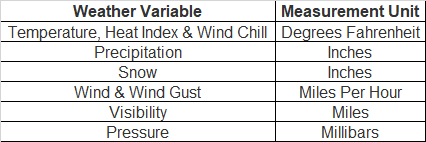

I defined a function to get the climate data into a dataframe and use it further on for multiple locations. The first one is for testing wether the location has Weather Data or not.Since it is a subscribed limited service, I did not want to use too much credit for places that do not have data. The second one brings a week's data for all beach locations.

I stored all data in a csv file and combined them to use for further use in this project. You can see the function I used to get the data form this service and the loop I used to get the data and store it in a csv below:


I defined a function to get the climate data into a dataframe and use it further on for multiple locations:

In [16]:
#Downloading weather data using Python as a CSV using the Visual Crossing Weather API
#See https://www.visualcrossing.com/resources/blog/how-to-load-historical-weather-data-using-python-without-scraping/ for more information.

def getClimateInfo(names):
        df = pd.DataFrame(columns=['Beach', 'Date', 'MinTemp', 'MaxTemp', 'AvTemp', 'Humidity', 'Precipitation'])

        # Date format must be yyyy-M-d
        pars = ["GE", names, "HISTORY", VISUALC, "2017-07-5", "2017-07-11" ]


        # This is the core of our weather query URL
        BaseURL = 'http://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/'

        print('')
        print(' - Requesting weather for: ', pars[1])

        # Set up the location parameter for our query
        QueryLocation = '&location=' + urllib.parse.quote(pars[1])

        # Set up the query type parameter for our query ('FORECAST' or 'HISTORY')
        QueryType=pars[2].upper()

        # Set up the key parameter for our query
        QueryKey = '&key=' + pars[3]

        # Set up the date parameters for our query. Used only for historical weather data requests
        FromDateParam =  pars[4]
        ToDateParam =  pars[5]

        # Set up the specific parameters based on the type of query
        if QueryType == 'FORECAST':
            print(' - Fetching forecast data')
            QueryTypeParams = 'forecast?&aggregateHours=24&unitGroup=us&shortColumnNames=false'
        else:
            print(' - Fetching history for date: ', FromDateParam,'-',ToDateParam)

            # History requests require a date.  We use the same date for start and end since we only want to query a single date in this example
            QueryDate = '&startDateTime=' + FromDateParam + 'T00:00:00&endDateTime=' + ToDateParam + 'T00:00:00'
            QueryTypeParams = 'history?&aggregateHours=24&unitGroup=us&dayStartTime=0:0:00&dayEndTime=0:0:00' + QueryDate


            # Build the entire query
            URL = BaseURL + QueryTypeParams + QueryLocation + QueryKey

            print(' - Running query URL: ', URL)
            print()

            # Parse the results as CSV
            CSVBytes = urllib.request.urlopen(URL)
            CSVText = csv.reader(codecs.iterdecode(CSVBytes, 'utf-8'))

        #The API returns these values for HISTORY: Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,
        #Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,
        #Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,
        #Resolved Address,Name,Info,Conditions
        
        RowIndex = 0
        
        mintemp='' 
        maxtemp=''
        avtemp = '' 
        humidi = ''
        precipi = ''
        
        # The first row contain the headers and the additional rows each contain the weather metrics for a single day
        # To simply our code, we use the knowledge that column 0 contains the location and column 1 contains the date.  The data starts at column 4
        for Row in CSVText:
            if RowIndex == 0:
                FirstRow = Row
            else:
                # print('Weather in ', Row[0], ' on ', Row[1])
                ColIndex = 0
                for Col in Row:
                    if ColIndex == 2:
                        print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                        mintemp = Row[ColIndex]
                    else:
                        if ColIndex == 3:
                            print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                            maxtemp = Row[ColIndex]
                        else: 
                            if ColIndex == 4:
                                print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                                avtemp = Row[ColIndex]
                            else: 
                                if ColIndex == 6:
                                    print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                                    humidi = Row[ColIndex]
                                else: 
                                    if ColIndex == 12:
                                        print('   ', FirstRow[ColIndex], ' = ', Row[ColIndex])
                                        precipi = Row[ColIndex]
                    new_row = {'Beach': Row[0], 'Date': Row[1], 'MinTemp': mintemp, 'MaxTemp': maxtemp, 'AvTemp': avtemp, 'Humidity': humidi, 'Precipitation': precipi}
                    ColIndex += 1
                df=df.append(new_row, ignore_index=True)
            RowIndex += 1

        # If there are no CSV rows then something fundamental went wrong
        if RowIndex == 0:
            print('Sorry, but it appears that there was an error connecting to the weather server.')
            print('Please check your network connection and try again..')

        # If there is only one CSV  row then we likely got an error from the server
        if RowIndex == 1:
            print('Sorry, but it appears that there was an error retrieving the weather data.')
            print('Error: ', FirstRow)

        print()
        return(df)

I get the climate information from Virtual Crossings API for all beaches in my list. (You have to check whether the location  is in their database or not if you want to use)

In [491]:
dfClimate = pd.DataFrame(columns=['Beach', 'Date', 'MinTemp', 'MaxTemp', 'AvTemp', 'Humidity', 'Precipitation'])

dfClimate1 = dfClimate
for index in range(len(dfBeach)):
    a=dfBeach['Beach'][index]
    dfTemp = getClimateInfo(a)
    dfClimate1 = dfClimate1.append(dfTemp)
dfClimate1


 - Requesting weather for:  Alanya, Turkey
 - Fetching history for date:  2019-07-5 - 2019-07-11
 - Running query URL:  http://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=24&unitGroup=us&dayStartTime=0:0:00&dayEndTime=0:0:00&startDateTime=2019-07-5T00:00:00&endDateTime=2019-07-11T00:00:00&location=Alanya%2C%20Turkey&key=Y2UFS7PGJBNJRATCQ0Z5SLGMV

    Minimum Temperature  =  66.3
    Maximum Temperature  =  87
    Temperature  =  79.5
    Relative Humidity  =  81.53
    Precipitation  =  0
    Minimum Temperature  =  66.3
    Maximum Temperature  =  91.5
    Temperature  =  81.4
    Relative Humidity  =  74.62
    Precipitation  =  0
    Minimum Temperature  =  69.9
    Maximum Temperature  =  90.8
    Temperature  =  82.5
    Relative Humidity  =  69.5
    Precipitation  =  0
    Minimum Temperature  =  68.1
    Maximum Temperature  =  89
    Temperature  =  82.1
    Relative Humidity  =  71.3
    Precipitation  =  0
    Minim

,Beach,Date,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Alanya, Turkey",07/05/2019,66.3,87,79.5,81.53,0
1,"Alanya, Turkey",07/06/2019,66.3,91.5,81.4,74.62,0
2,"Alanya, Turkey",07/07/2019,69.9,90.8,82.5,69.5,0
3,"Alanya, Turkey",07/08/2019,68.1,89,82.1,71.3,0
4,"Alanya, Turkey",07/09/2019,71.7,89.9,81.8,77.97,0
5,"Alanya, Turkey",07/10/2019,66.3,89.9,81.7,77.23,0
6,"Alanya, Turkey",07/11/2019,69.9,90.8,83,71.96,0
0,"Miami Beach, Florida",07/05/2019,84.2,87.2,85.8,69.51,0
1,"Miami Beach, Florida",07/06/2019,80.7,85.5,83.9,73.12,0.4
2,"Miami Beach, Florida",07/07/2019,78.6,86.8,84,71.7,0


In [36]:
# dfClimate1.to_csv('d:\ds\BeachClimate.csv', index=False ) # Duzelt

After I collected 2017-2019 data from the service, I combined them all in BeachClimateFull.csv to use for this project. There was both a daily limit for importing data.So 3 years looked enough for me. This could be extended if necessary.

In [17]:
dfBeachClimate3 =pd.read_csv('d:\ds\BeachClimateFull.csv')
dfBeachClimate3.head()


,Beach,Date,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Saray, Alanya",07/05/2017,68.1,91.1,82.2,71.56,0.0
1,"Saray, Alanya",07/06/2017,68.1,89.7,82.2,70.53,0.0
2,"Saray, Alanya",07/07/2017,69.9,96.2,84.6,62.88,0.0
3,"Saray, Alanya",07/08/2017,71.7,93.5,88.5,36.87,0.0
4,"Saray, Alanya",07/09/2017,66.3,95.1,83.4,54.00,0.0


Let's have a look at the climate data statistics we have in hand.

In [18]:
dfBeachClimate3.describe()

,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
count,210.000000,210.000000,210.000000,210.000000,210.000000
mean,70.088571,86.228571,78.102381,71.175190,0.141905
std,8.178286,6.951902,6.346264,11.483455,0.368699
min,45.100000,64.600000,61.800000,36.870000,0.000000
25%,65.900000,82.625000,74.200000,64.832500,0.000000
50%,71.900000,87.700000,79.900000,71.830000,0.000000
75%,75.575000,90.800000,82.675000,78.342500,0.100000
max,84.800000,107.700000,88.700000,95.200000,2.300000


I needed to convert the datatypes to numeric, in case.

In [19]:
#cols = dfBeachClimate.columns[dfBeachClimate.dtypes.eq(object)]
# Actually, `cols` can be any list of columns you need to convert.
cols = ['MinTemp', 'MaxTemp', 'AvTemp', 'Humidity', 'Precipitation']
# Index(['B', 'D'], dtype='object')

# dfBeachClimate3 = dfBeachClimate3.drop(columns=['Date'], inplace=True)
dfBeachClimate3[cols] = dfBeachClimate3[cols].apply(pd.to_numeric, errors='coerce')
dfBeachClimate3.drop(columns=['Date'], inplace=True)
dfBeachClimate3.head()        

,Beach,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Saray, Alanya",68.1,91.1,82.2,71.56,0.0
1,"Saray, Alanya",68.1,89.7,82.2,70.53,0.0
2,"Saray, Alanya",69.9,96.2,84.6,62.88,0.0
3,"Saray, Alanya",71.7,93.5,88.5,36.87,0.0
4,"Saray, Alanya",66.3,95.1,83.4,54.00,0.0


I have to groupby the list by location. I will use all the 3 years' averages, which should give a good normalization for weather data. 5-7 years is better but with the limitation of free services...

In [20]:
dfBeachClimateAgg = dfBeachClimate3.groupby(['Beach']).mean().reset_index()

In [21]:
dfBeachClimateAgg

,Beach,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Destin, Florida",78.200000,89.876190,84.052381,72.310952,0.285714
1,"Laguna Beach, California",67.795238,84.014286,74.500000,65.829524,0.000000
2,"Miami Beach, Florida",78.761905,88.800000,83.904762,72.576190,0.323810
3,"Myrtle Beach, South Carolina",73.552381,87.480952,80.719048,78.444762,0.204762
4,"Ocean City, Maryland",69.490476,81.738095,75.785714,81.289524,0.090476
5,"Outer Banks, North Carolina",70.790476,90.000000,79.223810,75.210000,0.238095
6,"Ruby Beach, Washington",52.719048,83.485714,68.514286,52.547143,0.009524
7,"Santa Monica,Los Angeles",66.366667,77.361905,71.223810,75.585238,0.000000
8,"Saray, Alanya",71.404762,91.819048,83.642857,64.956190,0.000000
9,"Virginia Beach, Virginia",71.804762,87.709524,79.457143,73.002381,0.266667


Now let's normalize the climate data further in order to find statisticly sound distribution. A wayto do this is min-max normalizatgion approach. However this method is quite prone to the effect of outliers. 
<br> <br>
<strong> 
So I used the difference between temperature data and Normal Temperature 68 Degrees Fahrenheit(20 Degrees Celsius) and then normalize our temperature data.
<br> <br>
For Relative Humidity 50 is an acceptable comfort level. ( "Winter Indoor Comfort and Relative Humidity", Information please (database), Pearson, 2007)
</strong>

Precipitation will not be modified prior to normalization.

In [22]:
dfBeachClimateAgg['MinTemp']=dfBeachClimateAgg['MinTemp']-68
dfBeachClimateAgg['MaxTemp']=dfBeachClimateAgg['MaxTemp']-68
dfBeachClimateAgg['AvTemp']=dfBeachClimateAgg['AvTemp']-68
dfBeachClimateAgg['Humidity']=dfBeachClimateAgg['Humidity']-50
dfBeachClimateAgg

,Beach,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Destin, Florida",10.200000,21.876190,16.052381,22.310952,0.285714
1,"Laguna Beach, California",-0.204762,16.014286,6.500000,15.829524,0.000000
2,"Miami Beach, Florida",10.761905,20.800000,15.904762,22.576190,0.323810
3,"Myrtle Beach, South Carolina",5.552381,19.480952,12.719048,28.444762,0.204762
4,"Ocean City, Maryland",1.490476,13.738095,7.785714,31.289524,0.090476
5,"Outer Banks, North Carolina",2.790476,22.000000,11.223810,25.210000,0.238095
6,"Ruby Beach, Washington",-15.280952,15.485714,0.514286,2.547143,0.009524
7,"Santa Monica,Los Angeles",-1.633333,9.361905,3.223810,25.585238,0.000000
8,"Saray, Alanya",3.404762,23.819048,15.642857,14.956190,0.000000
9,"Virginia Beach, Virginia",3.804762,19.709524,11.457143,23.002381,0.266667


This way we have reached an average of values for climate data which we will use for clustering.

Now I would like to normalize this data in order to make it meaningful next to venu data which will also be normalized.I will use min-max normalization, as there are not many outliers that might create problems.

In [23]:
def normalize(df, collist):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name in collist:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        else:
            result[feature_name] == df[feature_name] 
    return result

In [24]:
column_names_to_normalize = ['MinTemp', 'MaxTemp', 'AvTemp', 'Humidity','Precipitation']
dfBeachClimateAggNorm=normalize(dfBeachClimateAgg,column_names_to_normalize)

In [25]:
dfBeachClimateAggNorm

,Beach,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Destin, Florida",0.978424,0.865613,1.000000,0.687619,0.882353
1,"Laguna Beach, California",0.578899,0.460145,0.385228,0.462118,0.000000
2,"Miami Beach, Florida",1.000000,0.791173,0.990500,0.696847,1.000000
3,"Myrtle Beach, South Carolina",0.799963,0.699934,0.785473,0.901026,0.632353
4,"Ocean City, Maryland",0.643993,0.302701,0.467974,1.000000,0.279412
5,"Outer Banks, North Carolina",0.693911,0.874177,0.689243,0.788482,0.735294
6,"Ruby Beach, Washington",0.000000,0.423584,0.000000,0.000000,0.029412
7,"Santa Monica,Los Angeles",0.524045,0.000000,0.174379,0.801537,0.000000
8,"Saray, Alanya",0.717499,1.000000,0.973644,0.431733,0.000000
9,"Virginia Beach, Virginia",0.732858,0.715744,0.704260,0.711675,0.823529


This normalized data set will be used for Clustering purposes.

#### 4.2 Beach Venues

We will collect information about the venues near the beaches now.

Let's remember our beach list and normalize Ratings as well.

In [27]:
dfBeach

,Beach,Latitude,Longitude,BeachRating
0,"Miami Beach, Florida",25.792920,-80.135301,9.5
1,"Santa Monica,Los Angeles",34.025072,-118.496513,9.2
2,"Virginia Beach, Virginia",36.852984,-75.977418,8.5
3,"Destin, Florida",30.393534,-86.495783,9.0
4,"Outer Banks, North Carolina",35.566847,-75.468491,8.4
5,"Laguna Beach, California",33.542698,-117.785366,9.6
6,"Ocean City, Maryland",38.334873,-75.084766,8.8
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,9.0
8,"Ruby Beach, Washington",47.719454,-124.419188,10.0
9,"Saray, Alanya",36.549983,31.979935,10.0


In [59]:
column_names_to_normalize = ['BeachRating']
dfBeach=normalize(dfBeach,column_names_to_normalize)
dfBeach

,Beach,Latitude,Longitude,BeachRating
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625
3,"Destin, Florida",30.393534,-86.495783,0.3750
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000
5,"Laguna Beach, California",33.542698,-117.785366,0.7500
6,"Ocean City, Maryland",38.334873,-75.084766,0.2500
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,0.3750
8,"Ruby Beach, Washington",47.719454,-124.419188,1.0000
9,"Saray, Alanya",36.549983,31.979935,1.0000


I did not want to use the assigned Foursquare categories directly. I used the main categories in Foursquare Categories List.I donloaded the Json file and created a csv file to be used further on for reaching the main categories of venues.

In [32]:
# Algorithm to create a csv file of categories.
# I use it for finding the main category of the venue category

from collections import defaultdict
import requests
import pandas as pd

#API Parameters
CATEGORIES_API = 'https://api.foursquare.com/v2/venues/categories'
PARAMS = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'v': VERSION
}

# a dictionary to store subcategory (key) and all of its possible parents
SUBCATEGORIES = {}


def subcategorize(cat, prev):
    if cat.get('categories', False):
        
        lvl = len(prev)-1
        for subcat in cat['categories']:
            
            child = subcat['name']
            subcategorize(subcat, prev+[child])
            if child not in SUBCATEGORIES:
                SUBCATEGORIES[child] = [(prev[0], 0)]
                
            for i in range(1, lvl+1):
                SUBCATEGORIES[child].append((prev[i], i))

#fetch categories from api
response = requests.get(CATEGORIES_API, params=PARAMS).json()

#subcategorize each category
for cat in response['response']['categories']:
    name = cat['name']
    subcategorize(cat, [name])

#populate a dataframe from SUBCATEGORIES dictionary
dfCat = pd.DataFrame(columns = ['venue', 'venue_category', 'level'])
for k, v in SUBCATEGORIES.items():
    for sub, lvl in v:
        dfCat.loc[len(dfCat)] = (k, sub, lvl)

dfCat.to_csv('d:\ds\FSCat.csv', index=False ) # Duzelt

In [60]:
dfCat=pd.read_csv('d:\ds\FSCat.csv')
dfCat

,venue,venue_category,level
0,Amphitheater,Arts & Entertainment,0
1,Aquarium,Arts & Entertainment,0
2,Arcade,Arts & Entertainment,0
3,Art Gallery,Arts & Entertainment,0
4,Bowling Alley,Arts & Entertainment,0
5,Casino,Arts & Entertainment,0
6,Circus,Arts & Entertainment,0
7,Comedy Club,Arts & Entertainment,0
8,Concert Hall,Arts & Entertainment,0
9,Country Dance Club,Arts & Entertainment,0


A function for main category finding.

In [61]:
def getMainCategory(str2):
    amc="venue == '" + str2 + "' and level == 0"
    str2=dfCat.query(amc).iloc[0]['venue_category']
    return(str2)

Test the function.

In [62]:
getMainCategory('Turkish Restaurant')

'Food'

Now we define the function to get the nearby venues to a location, <strong> which retruns the venue, location information and the main category of the venue.
</strong> 

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    getMainCategory(v['venue']['categories'][0]['name']))])
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Beach', 
                  'Beach Latitude', 
                  'Beach Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We will get the venues list in 2000 metres, 15 closest and use them later for clustering the beaches. This is to understanfd what is available at the beach in a 30 minutes walking distance aorund 2.000 metres.

In [64]:
LIMIT=15
beach_venues = getNearbyVenues(names=dfBeach['Beach'],
                                   latitudes=dfBeach['Latitude'],
                                   longitudes=dfBeach['Longitude'],
                                   radius=2000
                                  )

Miami Beach, Florida
Santa Monica,Los Angeles
Virginia Beach, Virginia
Destin, Florida
Outer Banks, North Carolina
Laguna Beach, California
Ocean City, Maryland
Myrtle Beach, South Carolina
Ruby Beach, Washington
Saray, Alanya


Here is a list of venues in 2,000 metres to our short list of beaches:

In [65]:
print(beach_venues.shape)
beach_venues

(137, 7)


,Beach,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Miami Beach, Florida",25.792920,-80.135301,Art Basel,25.794563,-80.134187,Arts & Entertainment
1,"Miami Beach, Florida",25.792920,-80.135301,The Fillmore Miami Beach at The Jackie Gleason...,25.792886,-80.133284,Arts & Entertainment
2,"Miami Beach, Florida",25.792920,-80.135301,Lincoln Road Mall,25.790671,-80.135359,Shop & Service
3,"Miami Beach, Florida",25.792920,-80.135301,SoundScape Park at the New World Center,25.791822,-80.132611,Arts & Entertainment
4,"Miami Beach, Florida",25.792920,-80.135301,Victoria's Secret,25.790792,-80.137835,Shop & Service
5,"Miami Beach, Florida",25.792920,-80.135301,Lincoln Road,25.790679,-80.132704,Travel & Transport
6,"Miami Beach, Florida",25.792920,-80.135301,New World Symphony,25.791340,-80.133365,Arts & Entertainment
7,"Miami Beach, Florida",25.792920,-80.135301,Books & Books Bookstore,25.790930,-80.138260,Shop & Service
8,"Miami Beach, Florida",25.792920,-80.135301,Rosetta Bakery,25.791300,-80.140020,Food
9,"Miami Beach, Florida",25.792920,-80.135301,Carrot Express,25.793187,-80.140900,Food


Let's check how many venues were returned for each Beach

In [66]:
beach_venues.groupby('Beach').count()

,Beach Latitude,Beach Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Beach,,,,,,
"Destin, Florida",15,15,15,15,15,15
"Laguna Beach, California",15,15,15,15,15,15
"Miami Beach, Florida",15,15,15,15,15,15
"Myrtle Beach, South Carolina",15,15,15,15,15,15
"Ocean City, Maryland",15,15,15,15,15,15
"Outer Banks, North Carolina",15,15,15,15,15,15
"Ruby Beach, Washington",2,2,2,2,2,2
"Santa Monica,Los Angeles",15,15,15,15,15,15
"Saray, Alanya",15,15,15,15,15,15


Let's find out how many unique categories can be curated from all the returned venues

In [67]:
print('There are {} uniques categories.'.format(len(beach_venues['Venue Category'].unique())))

There are 6 uniques categories.


In [94]:
a=beach_venues['Venue Category'].unique()
a

array(['Arts & Entertainment', 'Shop & Service', 'Travel & Transport',
       'Food', 'Nightlife Spot', 'Outdoors & Recreation'], dtype=object)

Venue Distribution of Venue Types in Beaches

In [68]:
# one hot encoding
beach_onehot = pd.get_dummies(beach_venues[['Venue Category']], prefix="", prefix_sep="")

# add Beach column back to dataframe
beach_onehot['Beach'] = beach_venues['Beach'] 

# move Beach column to the first column
fixed_columns = [beach_onehot.columns[-1]] + list(beach_onehot.columns[:-1])
beach_onehot = beach_onehot[fixed_columns]

beach_onehot.head()

,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,"Miami Beach, Florida",1,0,0,0,0,0
1,"Miami Beach, Florida",1,0,0,0,0,0
2,"Miami Beach, Florida",0,0,0,0,1,0
3,"Miami Beach, Florida",1,0,0,0,0,0
4,"Miami Beach, Florida",0,0,0,0,1,0


In [69]:
beach_onehot.shape

(137, 7)

In [70]:
beach_grouped = beach_onehot.groupby('Beach').mean().reset_index()
beach_grouped

,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,"Destin, Florida",0.000000,0.666667,0.133333,0.066667,0.133333,0.000000
1,"Laguna Beach, California",0.066667,0.666667,0.000000,0.266667,0.000000,0.000000
2,"Miami Beach, Florida",0.266667,0.400000,0.066667,0.000000,0.200000,0.066667
3,"Myrtle Beach, South Carolina",0.000000,0.666667,0.266667,0.000000,0.066667,0.000000
4,"Ocean City, Maryland",0.066667,0.200000,0.266667,0.266667,0.200000,0.000000
5,"Outer Banks, North Carolina",0.000000,0.400000,0.066667,0.133333,0.333333,0.066667
6,"Ruby Beach, Washington",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,"Santa Monica,Los Angeles",0.000000,0.866667,0.000000,0.133333,0.000000,0.000000
8,"Saray, Alanya",0.000000,0.400000,0.000000,0.400000,0.066667,0.133333
9,"Virginia Beach, Virginia",0.066667,0.333333,0.000000,0.466667,0.000000,0.133333


In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We will check what is the most common spots near the beaches.

In [96]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Beach']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Category'.format(ind+1))

# create a new dataframe
Beachs_venues_sorted = pd.DataFrame(columns=columns)
Beachs_venues_sorted['Beach'] = beach_grouped['Beach']

for ind in np.arange(beach_grouped.shape[0]):
    Beachs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(beach_grouped.iloc[ind, :], num_top_venues)

Beachs_venues_sorted

,Beach,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category
0,"Destin, Florida",Food,Shop & Service,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Arts & Entertainment
1,"Laguna Beach, California",Food,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Shop & Service,Nightlife Spot
2,"Miami Beach, Florida",Food,Arts & Entertainment,Shop & Service,Travel & Transport,Nightlife Spot,Outdoors & Recreation
3,"Myrtle Beach, South Carolina",Food,Nightlife Spot,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment
4,"Ocean City, Maryland",Outdoors & Recreation,Nightlife Spot,Shop & Service,Food,Arts & Entertainment,Travel & Transport
5,"Outer Banks, North Carolina",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment
6,"Ruby Beach, Washington",Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Food,Arts & Entertainment
7,"Santa Monica,Los Angeles",Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment
8,"Saray, Alanya",Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment
9,"Virginia Beach, Virginia",Outdoors & Recreation,Food,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot


## 5. Cluster Beaches

In order to understand the similarities between the shortlist of beaches we have chose and our favorite beach (beaches) we added to the list, we will use clustering methods. K-Means and DBSCAN.

First we will try K-Means without the climate data, and then we will see the differences when we run the clustering with climate data. LAst we will try DBSCAN and see if it has to offer any insight.

### 5.1 K-Means Clustering Only With Venues Data (Without Climate Data)

Run *k*-means to cluster the Beach into 5 clusters.

In [73]:
beach_data = dfBeach

beach_merged1 = beach_data
beach_merged1 = beach_merged1.join(beach_grouped.set_index('Beach'), on='Beach')
beach_merged1

,Beach,Latitude,Longitude,BeachRating,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875,0.266667,0.400000,0.066667,0.000000,0.200000,0.066667
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000,0.000000,0.866667,0.000000,0.133333,0.000000,0.000000
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625,0.066667,0.333333,0.000000,0.466667,0.000000,0.133333
3,"Destin, Florida",30.393534,-86.495783,0.3750,0.000000,0.666667,0.133333,0.066667,0.133333,0.000000
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000,0.000000,0.400000,0.066667,0.133333,0.333333,0.066667
5,"Laguna Beach, California",33.542698,-117.785366,0.7500,0.066667,0.666667,0.000000,0.266667,0.000000,0.000000
6,"Ocean City, Maryland",38.334873,-75.084766,0.2500,0.066667,0.200000,0.266667,0.266667,0.200000,0.000000
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,0.3750,0.000000,0.666667,0.266667,0.000000,0.066667,0.000000
8,"Ruby Beach, Washington",47.719454,-124.419188,1.0000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
9,"Saray, Alanya",36.549983,31.979935,1.0000,0.000000,0.400000,0.000000,0.400000,0.066667,0.133333


In [74]:
beach_merged1 = beach_merged1.fillna(0)
beach_merged1

,Beach,Latitude,Longitude,BeachRating,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875,0.266667,0.400000,0.066667,0.000000,0.200000,0.066667
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000,0.000000,0.866667,0.000000,0.133333,0.000000,0.000000
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625,0.066667,0.333333,0.000000,0.466667,0.000000,0.133333
3,"Destin, Florida",30.393534,-86.495783,0.3750,0.000000,0.666667,0.133333,0.066667,0.133333,0.000000
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000,0.000000,0.400000,0.066667,0.133333,0.333333,0.066667
5,"Laguna Beach, California",33.542698,-117.785366,0.7500,0.066667,0.666667,0.000000,0.266667,0.000000,0.000000
6,"Ocean City, Maryland",38.334873,-75.084766,0.2500,0.066667,0.200000,0.266667,0.266667,0.200000,0.000000
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,0.3750,0.000000,0.666667,0.266667,0.000000,0.066667,0.000000
8,"Ruby Beach, Washington",47.719454,-124.419188,1.0000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
9,"Saray, Alanya",36.549983,31.979935,1.0000,0.000000,0.400000,0.000000,0.400000,0.066667,0.133333


Run *k*-means to cluster the Beach into 5 clusters.

In [75]:
# set number of clusters
kclusters = 3

beach_grouped_clustering = beach_merged1.drop(['Beach', 'Latitude', 'Longitude' ], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(beach_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 1, 2, 1, 2, 1, 0, 0])

In [76]:
# add clustering labels
Beachs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

beach_merged = beach_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each Beach
beach_merged = beach_merged.join(Beachs_venues_sorted.set_index('Beach'), on='Beach')

beach_merged

,Beach,Latitude,Longitude,BeachRating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875,2,Food,Arts & Entertainment,Shop & Service,Travel & Transport,Nightlife Spot,Outdoors & Recreation
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000,1,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625,0,Outdoors & Recreation,Food,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot
3,"Destin, Florida",30.393534,-86.495783,0.3750,1,Food,Shop & Service,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Arts & Entertainment
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000,1,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment
5,"Laguna Beach, California",33.542698,-117.785366,0.7500,1,Food,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Shop & Service,Nightlife Spot
6,"Ocean City, Maryland",38.334873,-75.084766,0.2500,2,Outdoors & Recreation,Nightlife Spot,Shop & Service,Food,Arts & Entertainment,Travel & Transport
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,0.3750,1,Food,Nightlife Spot,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment
8,"Ruby Beach, Washington",47.719454,-124.419188,1.0000,2,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Food,Arts & Entertainment
9,"Saray, Alanya",36.549983,31.979935,1.0000,0,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment


In [77]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(beach_merged['Latitude'], beach_merged['Longitude'], beach_merged['Beach'], beach_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5.2 Cluster Based Analysis Including Climate Data

Now let's analyze the clustering results with climate data.

In [78]:
beach_data = dfBeach
beach_data.head()

beach_merged1 = beach_grouped
beach_merged1 = beach_merged1.join(beach_data.set_index('Beach'), on='Beach')
beach_merged1 = beach_merged1.join(dfBeachClimateAggNorm.set_index('Beach'), on='Beach')
beach_merged1

,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude,BeachRating,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Destin, Florida",0.000000,0.666667,0.133333,0.066667,0.133333,0.000000,30.393534,-86.495783,0.3750,0.978424,0.865613,1.000000,0.687619,0.882353
1,"Laguna Beach, California",0.066667,0.666667,0.000000,0.266667,0.000000,0.000000,33.542698,-117.785366,0.7500,0.578899,0.460145,0.385228,0.462118,0.000000
2,"Miami Beach, Florida",0.266667,0.400000,0.066667,0.000000,0.200000,0.066667,25.792920,-80.135301,0.6875,1.000000,0.791173,0.990500,0.696847,1.000000
3,"Myrtle Beach, South Carolina",0.000000,0.666667,0.266667,0.000000,0.066667,0.000000,33.695646,-78.890041,0.3750,0.799963,0.699934,0.785473,0.901026,0.632353
4,"Ocean City, Maryland",0.066667,0.200000,0.266667,0.266667,0.200000,0.000000,38.334873,-75.084766,0.2500,0.643993,0.302701,0.467974,1.000000,0.279412
5,"Outer Banks, North Carolina",0.000000,0.400000,0.066667,0.133333,0.333333,0.066667,35.566847,-75.468491,0.0000,0.693911,0.874177,0.689243,0.788482,0.735294
6,"Ruby Beach, Washington",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.719454,-124.419188,1.0000,0.000000,0.423584,0.000000,0.000000,0.029412
7,"Santa Monica,Los Angeles",0.000000,0.866667,0.000000,0.133333,0.000000,0.000000,34.025072,-118.496513,0.5000,0.524045,0.000000,0.174379,0.801537,0.000000
8,"Saray, Alanya",0.000000,0.400000,0.000000,0.400000,0.066667,0.133333,36.549983,31.979935,1.0000,0.717499,1.000000,0.973644,0.431733,0.000000
9,"Virginia Beach, Virginia",0.066667,0.333333,0.000000,0.466667,0.000000,0.133333,36.852984,-75.977418,0.0625,0.732858,0.715744,0.704260,0.711675,0.823529


In [79]:
# set number of clusters
kclusters = 3

beach_grouped_clustering = beach_merged1.drop(['Beach', 'Latitude', 'Longitude' ], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(beach_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 2, 0, 1, 2, 2, 0])

In [80]:
# add clustering labels
Beachs_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)

Beachs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

beach_merged = beach_data

# merge toronto_grouped with data to add latitude/longitude for each Beach
beach_merged = beach_merged.join(Beachs_venues_sorted.set_index('Beach'), on='Beach')

beach_merged.head()

,Beach,Latitude,Longitude,BeachRating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875,0,Food,Arts & Entertainment,Shop & Service,Travel & Transport,Nightlife Spot,Outdoors & Recreation
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000,2,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625,0,Outdoors & Recreation,Food,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot
3,"Destin, Florida",30.393534,-86.495783,0.3750,0,Food,Shop & Service,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Arts & Entertainment
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000,0,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment


In [95]:
beach_merged

,Beach,Latitude,Longitude,BeachRating,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,"Miami Beach, Florida",25.792920,-80.135301,0.6875,0,Food,Arts & Entertainment,Shop & Service,Travel & Transport,Nightlife Spot,Outdoors & Recreation
1,"Santa Monica,Los Angeles",34.025072,-118.496513,0.5000,2,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment
2,"Virginia Beach, Virginia",36.852984,-75.977418,0.0625,0,Outdoors & Recreation,Food,Travel & Transport,Arts & Entertainment,Shop & Service,Nightlife Spot
3,"Destin, Florida",30.393534,-86.495783,0.3750,0,Food,Shop & Service,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Arts & Entertainment
4,"Outer Banks, North Carolina",35.566847,-75.468491,0.0000,0,Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment
5,"Laguna Beach, California",33.542698,-117.785366,0.7500,2,Food,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Shop & Service,Nightlife Spot
6,"Ocean City, Maryland",38.334873,-75.084766,0.2500,2,Outdoors & Recreation,Nightlife Spot,Shop & Service,Food,Arts & Entertainment,Travel & Transport
7,"Myrtle Beach, South Carolina",33.695646,-78.890041,0.3750,0,Food,Nightlife Spot,Shop & Service,Travel & Transport,Outdoors & Recreation,Arts & Entertainment
8,"Ruby Beach, Washington",47.719454,-124.419188,1.0000,1,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Food,Arts & Entertainment
9,"Saray, Alanya",36.549983,31.979935,1.0000,2,Outdoors & Recreation,Food,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment


In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(beach_merged['Latitude'], beach_merged['Longitude'], beach_merged['Beach'], beach_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 5.3 Clustering using DBSCAN

In K-Means Clustering we define the number of clusters . Plus we put some outliers in the basket too. In order to refine this let's try DBSCAN with Climate Data only.

In [82]:
beach_data = dfBeach
beach_data.head()

beach_merged1 = beach_grouped
beach_merged1 = beach_merged1.join(beach_data.set_index('Beach'), on='Beach')
beach_merged1 = beach_merged1.join(dfBeachClimateAggNorm.set_index('Beach'), on='Beach')
beach_merged1

,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude,BeachRating,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,"Destin, Florida",0.000000,0.666667,0.133333,0.066667,0.133333,0.000000,30.393534,-86.495783,0.3750,0.978424,0.865613,1.000000,0.687619,0.882353
1,"Laguna Beach, California",0.066667,0.666667,0.000000,0.266667,0.000000,0.000000,33.542698,-117.785366,0.7500,0.578899,0.460145,0.385228,0.462118,0.000000
2,"Miami Beach, Florida",0.266667,0.400000,0.066667,0.000000,0.200000,0.066667,25.792920,-80.135301,0.6875,1.000000,0.791173,0.990500,0.696847,1.000000
3,"Myrtle Beach, South Carolina",0.000000,0.666667,0.266667,0.000000,0.066667,0.000000,33.695646,-78.890041,0.3750,0.799963,0.699934,0.785473,0.901026,0.632353
4,"Ocean City, Maryland",0.066667,0.200000,0.266667,0.266667,0.200000,0.000000,38.334873,-75.084766,0.2500,0.643993,0.302701,0.467974,1.000000,0.279412
5,"Outer Banks, North Carolina",0.000000,0.400000,0.066667,0.133333,0.333333,0.066667,35.566847,-75.468491,0.0000,0.693911,0.874177,0.689243,0.788482,0.735294
6,"Ruby Beach, Washington",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.719454,-124.419188,1.0000,0.000000,0.423584,0.000000,0.000000,0.029412
7,"Santa Monica,Los Angeles",0.000000,0.866667,0.000000,0.133333,0.000000,0.000000,34.025072,-118.496513,0.5000,0.524045,0.000000,0.174379,0.801537,0.000000
8,"Saray, Alanya",0.000000,0.400000,0.000000,0.400000,0.066667,0.133333,36.549983,31.979935,1.0000,0.717499,1.000000,0.973644,0.431733,0.000000
9,"Virginia Beach, Virginia",0.066667,0.333333,0.000000,0.466667,0.000000,0.133333,36.852984,-75.977418,0.0625,0.732858,0.715744,0.704260,0.711675,0.823529


In [83]:
beach_merged1.insert(0, 'Cluster', '')
beach_merged1

,Cluster,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude,BeachRating,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,,"Destin, Florida",0.000000,0.666667,0.133333,0.066667,0.133333,0.000000,30.393534,-86.495783,0.3750,0.978424,0.865613,1.000000,0.687619,0.882353
1,,"Laguna Beach, California",0.066667,0.666667,0.000000,0.266667,0.000000,0.000000,33.542698,-117.785366,0.7500,0.578899,0.460145,0.385228,0.462118,0.000000
2,,"Miami Beach, Florida",0.266667,0.400000,0.066667,0.000000,0.200000,0.066667,25.792920,-80.135301,0.6875,1.000000,0.791173,0.990500,0.696847,1.000000
3,,"Myrtle Beach, South Carolina",0.000000,0.666667,0.266667,0.000000,0.066667,0.000000,33.695646,-78.890041,0.3750,0.799963,0.699934,0.785473,0.901026,0.632353
4,,"Ocean City, Maryland",0.066667,0.200000,0.266667,0.266667,0.200000,0.000000,38.334873,-75.084766,0.2500,0.643993,0.302701,0.467974,1.000000,0.279412
5,,"Outer Banks, North Carolina",0.000000,0.400000,0.066667,0.133333,0.333333,0.066667,35.566847,-75.468491,0.0000,0.693911,0.874177,0.689243,0.788482,0.735294
6,,"Ruby Beach, Washington",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.719454,-124.419188,1.0000,0.000000,0.423584,0.000000,0.000000,0.029412
7,,"Santa Monica,Los Angeles",0.000000,0.866667,0.000000,0.133333,0.000000,0.000000,34.025072,-118.496513,0.5000,0.524045,0.000000,0.174379,0.801537,0.000000
8,,"Saray, Alanya",0.000000,0.400000,0.000000,0.400000,0.066667,0.133333,36.549983,31.979935,1.0000,0.717499,1.000000,0.973644,0.431733,0.000000
9,,"Virginia Beach, Virginia",0.066667,0.333333,0.000000,0.466667,0.000000,0.133333,36.852984,-75.977418,0.0625,0.732858,0.715744,0.704260,0.711675,0.823529


In [84]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)

Clus_dataSet = beach_merged1[['BeachRating','MinTemp','MaxTemp','AvTemp','Humidity', 'Precipitation']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=1, min_samples=2).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
beach_merged1["Cluster"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
# pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)
beach_merged1

,Cluster,Beach,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude,BeachRating,MinTemp,MaxTemp,AvTemp,Humidity,Precipitation
0,-1,"Destin, Florida",0.000000,0.666667,0.133333,0.066667,0.133333,0.000000,30.393534,-86.495783,0.3750,0.978424,0.865613,1.000000,0.687619,0.882353
1,-1,"Laguna Beach, California",0.066667,0.666667,0.000000,0.266667,0.000000,0.000000,33.542698,-117.785366,0.7500,0.578899,0.460145,0.385228,0.462118,0.000000
2,-1,"Miami Beach, Florida",0.266667,0.400000,0.066667,0.000000,0.200000,0.066667,25.792920,-80.135301,0.6875,1.000000,0.791173,0.990500,0.696847,1.000000
3,-1,"Myrtle Beach, South Carolina",0.000000,0.666667,0.266667,0.000000,0.066667,0.000000,33.695646,-78.890041,0.3750,0.799963,0.699934,0.785473,0.901026,0.632353
4,-1,"Ocean City, Maryland",0.066667,0.200000,0.266667,0.266667,0.200000,0.000000,38.334873,-75.084766,0.2500,0.643993,0.302701,0.467974,1.000000,0.279412
5,0,"Outer Banks, North Carolina",0.000000,0.400000,0.066667,0.133333,0.333333,0.066667,35.566847,-75.468491,0.0000,0.693911,0.874177,0.689243,0.788482,0.735294
6,-1,"Ruby Beach, Washington",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.719454,-124.419188,1.0000,0.000000,0.423584,0.000000,0.000000,0.029412
7,-1,"Santa Monica,Los Angeles",0.000000,0.866667,0.000000,0.133333,0.000000,0.000000,34.025072,-118.496513,0.5000,0.524045,0.000000,0.174379,0.801537,0.000000
8,-1,"Saray, Alanya",0.000000,0.400000,0.000000,0.400000,0.066667,0.133333,36.549983,31.979935,1.0000,0.717499,1.000000,0.973644,0.431733,0.000000
9,0,"Virginia Beach, Virginia",0.066667,0.333333,0.000000,0.466667,0.000000,0.133333,36.852984,-75.977418,0.0625,0.732858,0.715744,0.704260,0.711675,0.823529


I did not see any valuable insight with the DBSCAN even though I changed the epsilon parameter. The data set is full of outliers accoring to DBSCAN analysis.


## 6. Conclusion

I have found out that California Beaches are more similar to Alanya, given the datasets I used. This is in line with what I have heard of the places from people like me. I have been to Ocean City, Maryland and I had realized how much it is alike with Alanya not only in terms of geographical conditions but also in terms of city facilities, the idea of being able to swim just next to your house etc. So the results here are astonishingly good.

On the other hand, East Coast beaches are clustered together. Except for the Northmost of them which again has a similarity with my favorite beach Kleopatra Beach in Saray, Alanya, Turkey. This tool might help me in my coice of this year's summer vacation. It could be detailed, and the parameters could be changed to see different results.
<br> <br>
<strong>Other conclusions I could derive from this  analysis are:</strong>
<ol>
<li>Climate data is very important in a location comparison. Especially if you are analyzing geographically distinct places.</li>
<li>The reviews and ratings on turism sites are not the only clue you should use. An outlier like the Ruby Beach in Washington for example might be confusing. Although it has good ratings this might be only due to availabilit, proximity to locals, whereas most people prefer more crowded beaches in the south, mostly California and Florida.</li>
<li>DBSCAN did not help where there were outliers to properly cluster and give some significant results. This could be because of too many parameters used for the  analysis.</li>
<li>Every conclusion is dependent on the data set you have. Reliable data is not easily found and bias can totally mislead us.</li>
<li>It is very important that some organizations publish their data free of charge for at least social use and I think they will be rewarded when someone creates value out of them.</li>
</ol>

## Information grows by sharing!

## Prepared by Gokhan Ekici 06/07/2020